In [1]:
import numpy as np

from optyx import optyx, zx, zw, lo
from optyx.channel import *

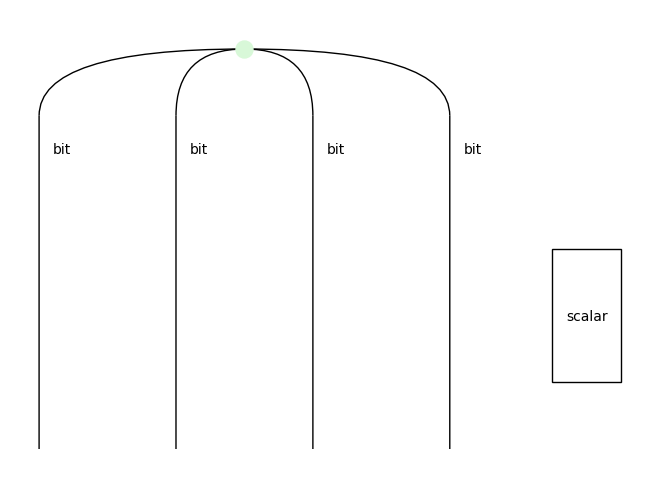

In [2]:
logical_ket_00 = zx.Z(0, 4) @ optyx.Scalar(1/np.sqrt(2))
Logical_ket_00 = Channel('|00>', logical_ket_00)

logical_ket_00.draw()

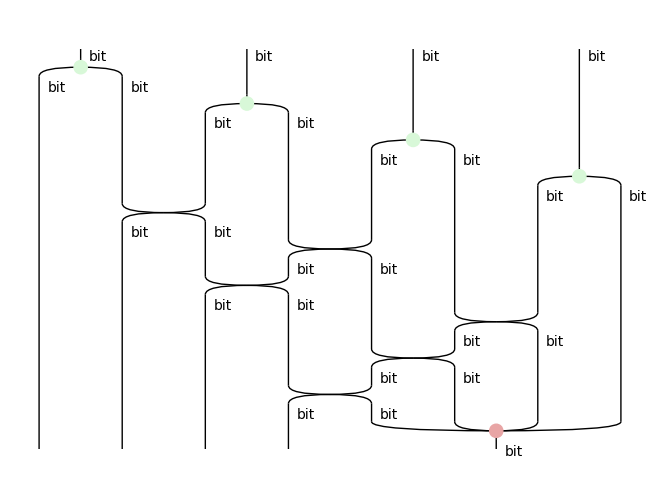

In [3]:
x_detector = (
        (zx.Z(1, 2) @ zx.Z(1, 2) @ zx.Z(1, 2) @ zx.Z(1, 2))
        >> optyx.Diagram.permutation([0, 2, 4, 6, 1, 3, 5, 7], optyx.bit ** 8)
        >> optyx.Id(optyx.bit ** 4) @ zx.X(4, 1)
)
X_detector = Channel('X Error Detector', x_detector, dom=qubit ** 4, cod=qubit**4 @ bit)

x_detector.draw()

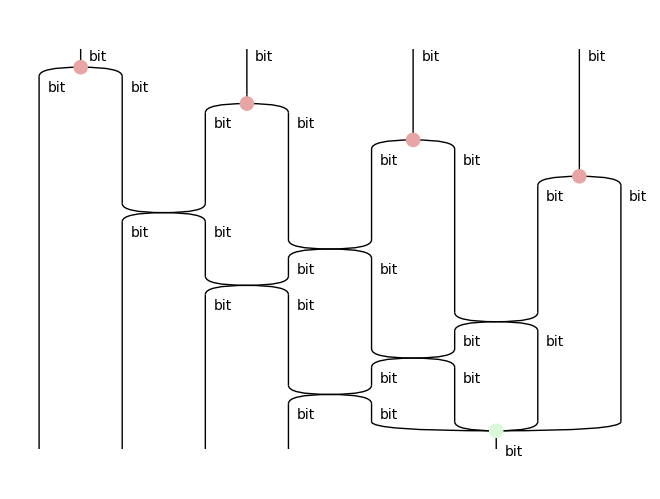

In [4]:
z_detector = (
        (zx.X(1, 2) @ zx.X(1, 2) @ zx.X(1, 2) @ zx.X(1, 2))
        >> optyx.Diagram.permutation([0, 2, 4, 6, 1, 3, 5, 7], optyx.bit ** 8)
        >> optyx.Id(optyx.bit ** 4) @ zx.Z(4, 1)
)
Z_detector = Channel('Z Error Detector', x_detector, dom=qubit ** 4, cod=qubit**4 @ bit)

z_detector.draw()

(3.749399456654641e-33+0j)


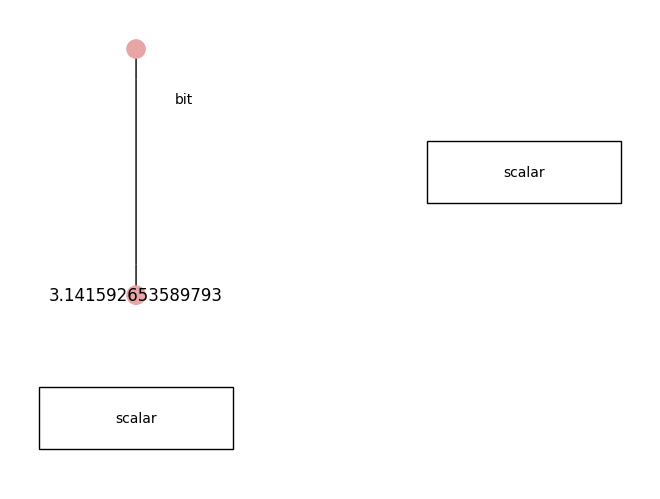

In [5]:
ket_0 = zx.X(0, 1) @ optyx.Scalar(1/np.sqrt(2))
Ket_0 = Channel('|0>', ket_0)

ket_1 = zx.X(0, 1, phase=np.pi) @ optyx.Scalar(1/np.sqrt(2))
Ket_1 = Channel('|1>', ket_1)

bra_0 = zx.X(1, 0) @ optyx.Scalar(1/np.sqrt(2))
Bra_0 = Channel('<0|', bra_0)

bra_1 = zx.X(1, 0, phase=np.pi) @ optyx.Scalar(1/np.sqrt(2))
Bra_1 = Channel('<1|', bra_1)

bra_plus = zx.Z(1, 0) @ optyx.Scalar(1/np.sqrt(2))
Bra_plus = Channel('<+|', bra_plus)

bra_minus = zx.Z(1, 0, phase=np.pi) @ optyx.Scalar(1/np.sqrt(2))
Bra_minus = Channel('<-|', bra_minus)

print((Ket_0 >> Bra_1).double().to_tensor().eval().array)
(ket_0 >> bra_1).draw()

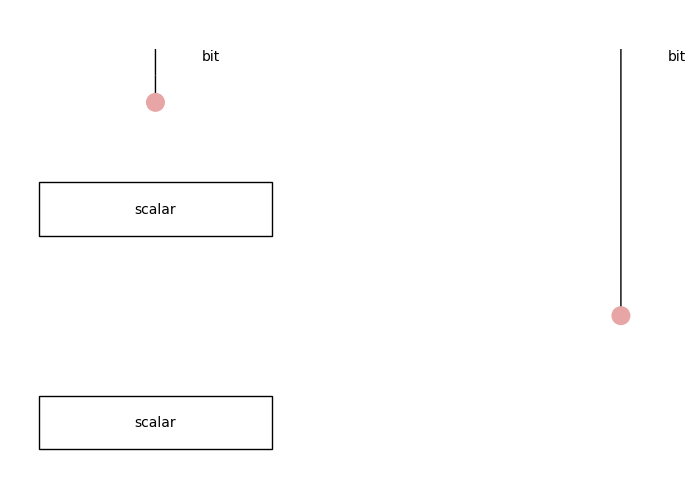

In [6]:
def diag_pow(diag, n):
    if n == 1:
        return diag
    return diag @ diag_pow(diag, n - 1)

bra_1 = zx.X(1, 0, phase=np.pi) @ optyx.Scalar(1/np.sqrt(2))
Bra_1 = Channel('<1|', bra_1)

diag_pow(bra_0, 2).draw()

0.4999999999999977


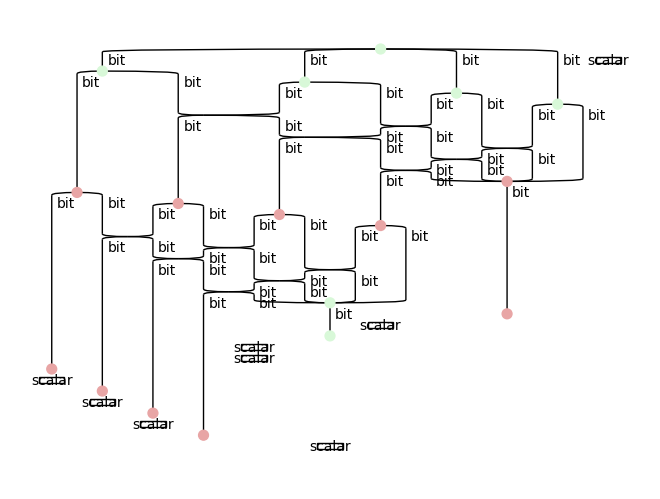

In [7]:
perfect_circuit = logical_ket_00 >> x_detector >> z_detector @ bra_0 >> optyx.Id(optyx.bit ** 4) @ bra_plus @ zx.Scalar(8) >>  diag_pow(bra_0, 4)

print(np.abs(perfect_circuit.to_tensor().eval().array) ** 2)
perfect_circuit.draw()

In [8]:
p = 0.9
state_mix = zx.ZBox(1,0, phase=np.sqrt((1-p)/p)) @ zx.Scalar(np.sqrt(p))

print(np.abs(state_mix.to_tensor().eval().array) ** 2)

[0.9 0.1]


In [9]:
Channel("Mix", state_mix).double().to_tensor().eval().array

array([[0.9+0.j, 0.9+0.j],
       [0.3+0.j, 0.3+0.j]])

In [11]:
diag = zx.Id(1) @ zx.Scalar(1) @ zx.Id(1)
Channel("Diagram", diag).double().to_tensor().eval().array

array([[[[[[[[1.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j]],

            [[0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j]]],


           [[[0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j]],

            [[0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j]]]],



          [[[[0.+0.j, 1.+0.j],
             [0.+0.j, 0.+0.j]],

            [[0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j]]],


           [[[0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j]],

            [[0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j]]]]],




         [[[[[0.+0.j, 0.+0.j],
             [1.+0.j, 0.+0.j]],

            [[0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j]]],


           [[[0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j]],

            [[0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j]]]],



          [[[[0.+0.j, 0.+0.j],
             [0.+0.j, 1.+0.j]],

            [[0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j]]],


           [[[0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j]],

            [[0.+0